In [1]:
import os
import sys

# Add Election Package to Path
ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2]) 
sys.path.append(ROOT_DIR)

from typing import Dict, Tuple, Optional, Set
import datetime
import json
from functools import reduce
from collections import defaultdict as ddict, namedtuple
import itertools
import pandas as pd
from pandas import DataFrame as DF, Series
import numpy as np
import networkx as nx
from networkx.algorithms import approximation as nxalg
from networkx.algorithms.components import connected as nxconn
import networkx.algorithms.centrality as nxcent
import pygraphviz as pgv
from fuzzywuzzy import process
from IPython.display import Image
from sandbox_ggemelos.transaction_analysis.graphs import DiGraph, Graph
from sandbox_ggemelos.transaction_analysis.utils import fetch_statement_of_org, fetch_transactions, calc_icdf, CachedProperty

import matplotlib.pyplot as plt
%matplotlib inline

/Users/ggemelos/anaconda3/envs/elections2018/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
DATA_PATH = os.path.join(ROOT_DIR, 'cleaned_data', 'cleaned_data')
START_DATE = datetime.date(2016, 11, 15)
END_DATE = datetime.date(2017, 11, 15)

In [3]:
def fetch_candidates() -> pd.DataFrame:
    return pd.read_csv(os.path.join(ROOT_DIR, 'misc_data', 'candidates.csv'), 
                       header=None, 
                       names=["name", "count"])

In [4]:
# Load data
state_org = fetch_statement_of_org()
trans = fetch_transactions(statement_of_org=state_org,
                           start_date=START_DATE,
                           end_date=END_DATE)

In [14]:
# Filter out bad payees 
invalid_payees = set(['Miscellaneous Cash Expenditures $100 and under', 
                      'Miscellaneous Cash Contributions $100 and under'])
trans['is_valid'] = trans['contributor_payee'].apply(lambda x: x != 'None' and x not in invalid_payees and x.count('$') == 0)
trans = trans[trans['is_valid']]

In [5]:
'''
Fuzzy Matching of Committees
FIXME: Need to come back to this
''' 
class CommitteMatch(object):
    def __init__(self, login_info, candidates):
        self._db_login = login_info
        self.candidates = fetch_candidates()
        
    def get_committee_matches(self, committee, top_n):
        return process.extract(committee, self.candidates, limit=top_n)

In [6]:
def build_graph_from_transaction(transactions: pd.DataFrame, total_donation_threshold=0, donation_threshold=0):
    '''
    Contructs a graph from dataframe of transactions

    :param transactions: Transaction data as returned by fetch_transaction
    :param total_donation_threshold: Minimum total amount per edge, sum of all donation between to parties (default: 0)
    :param donation_threshold: Minimum amount per donation (default: 0)
    :return: Graph
    '''
    payments = ddict(list)
    for sink, source, amount in transactions[['committee_id', 'contributor_payee', 'amount']].values:
        if abs(amount) < donation_threshold:
            continue
        if amount > 0:
            payments[(source, sink)].append(amount)
        else:
            payments[(sink, source)].append(-amount)

    edges = {key: sum(amount) for key, amount in payments.items() if sum(amount) >= total_donation_threshold}

    graph = DiGraph(edges=edges)

    # Print Stats
    percentiles = np.array([0, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

    degrees, counts = zip(*graph.degrees_out_counts.items())
    prct_out = calc_icdf(percentiles, counts, degrees)

    degrees, counts = zip(*graph.degrees_in_counts.items())
    prct_in = calc_icdf(percentiles, counts, degrees)

    total_donation_amount = np.array([amt for amt in edges.values()])
    donation_amount = np.abs(transactions['amount'])
    donation_amount = donation_amount[donation_amount >= DONATION_THRESHOLD]
    data = np.vstack((np.nanpercentile(total_donation_amount, percentiles * 100),
                      np.nanpercentile(donation_amount, percentiles * 100),
                      prct_in,
                      prct_out)).T

    df = pd.DataFrame(data=data,
                      columns=['Total Donation Amt', 'Per Donation Amt', 'In Bound Degree', 'Out Bound Degree'],
                      index=['{:,.2%}'.format(pp) for pp in percentiles])
    df['Total Donation Amt'] = df['Total Donation Amt'].apply(lambda x: '${:,.0f}'.format(x))
    df['Per Donation Amt'] = df['Per Donation Amt'].apply(lambda x: '${:,.0f}'.format(x))

    display(df)

    return graph

In [15]:
# Create Graph Components
DONATION_THRESHOLD = 100
TOTAL_DONATION_THRESHOLD = 100

graph = build_graph_from_transaction(transactions=trans, 
                                     donation_threshold=DONATION_THRESHOLD,
                                     total_donation_threshold=TOTAL_DONATION_THRESHOLD)

,Total Donation Amt,Per Donation Amt,In Bound Degree,Out Bound Degree
0.00%,$100,$100,0.0000,0.000000
25.00%,$200,$150,0.0000,0.245236
50.00%,$500,$295,0.0000,0.541789
75.00%,"$1,000",$806,0.0000,0.838341
90.00%,"$2,500","$2,000",0.0000,1.219752
95.00%,"$5,250","$4,871",0.0000,2.073992
99.00%,"$25,000","$15,000",35.2675,10.362143
99.90%,"$156,608","$66,525",149.8070,29.903500
99.99%,"$427,920","$259,137",1018.4261,60.129800


In [16]:
# Calculate connected components
ccsizes = sorted([ccomp.number_of_nodes() for ccomp in graph.conn_comp], reverse=True)
print('\nTop 10 comp: ' + ', '.join(('{:,.0f}'.format(ccsize) for ccsize in ccsizes[:10])))


Top 10 comp: 13,843, 58, 12, 11, 9, 8, 8, 8, 7, 7


Neighborhoods with and without bridging on sources


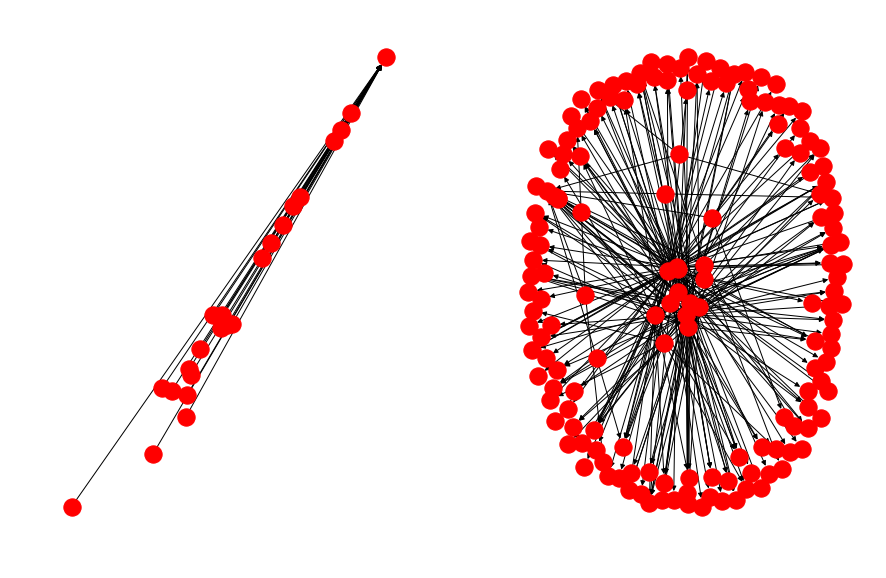

In [17]:
# Plot Neighborhood
node_name = 'Friends of Andy Olson'
nghd_wo_source_bridge = graph.get_neighborhood(node_name=node_name, 
                                               distance=2, 
                                               valid_bridging_node_ids=set(graph.sinks))
nghd_w_source_bridge = graph.get_neighborhood(node_name=node_name, 
                                              distance=2)
plt.figure(figsize=(15, 10))
plt.subplot(121)
nx.draw(nghd_wo_source_bridge, font_weight='bold')

plt.subplot(122)
nx.draw(nghd_w_source_bridge, font_weight='bold')
print('Neighborhoods with and without bridging on sources')

In [21]:
# Visualize in D3
node_name = 'Friends of Andy Olson'
nghd_wo_source_bridge = graph.get_neighborhood(node_name=node_name, 
                                               distance=2)

graph.show_in_d3_force_directed(file_path='/Users/ggemelos/Dropbox/documents/hackoregon/data/d3graph',
                                nodes=set(nghd_wo_source_bridge),
                                groups={'target': [graph.get_node_id(node_name)],
                                        'sources': [node_id for node_id in graph.sources if node_id != graph.get_node_id(node_name)]})

In [ ]:
# # BETWEENESS
# degree = graph.undirected_graph.degree
# sorted(((x, graph.get_node_name(x), degree[x], y) for x, y in nxcent.betweenness_centrality(graph.graph).items()), key=lambda x: x[3], reverse=True)

In [ ]:
# # EIGENVECTOR
# degree = graph.undirected_graph.degree
# sorted(((x, graph.get_node_name(x), degree[x], y) for x, y in nxcent.eigenvector_centrality(graph.graph).items()), key=lambda x: x[3], reverse=True)

In [ ]:
# # CLOSENESS
# degree = graph.undirected_graph.degree
# sorted(((x, graph.get_node_name(x), degree[x], y) for x, y in nxcent.closeness_centrality(graph.graph).items()), key=lambda x: x[3], reverse=True)